# HyperParameter Optimization and Feature Selection Post Modeling

This notebok uses the Tanzanian Waterpump Maintenance Dataset from Kaggle to test hyperparamter optimization using a variety of search methods. Then, the notebook will cover post modeling feature selection. It does not go into detail with pre-modeling feature selection. For that, reference [this notebook](tanzanian_water_pump_submission.ipynb). 

### Imports and Data Wrangling

In [1]:
%cd .. 
%cd data

/Users/azel/github/Tanzanian_Water_Pumps
/Users/azel/github/Tanzanian_Water_Pumps/data


In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from wrangle import note, low_occurance
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data         = pd.read_csv('train_features.csv')
feature_info = pd.read_csv('train_labels.csv')

feature_info = feature_info.drop(columns = 'id')

data = low_occurance(note(data))

data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,small_fry,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,small_fry,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
def finish_dataframe (data=data, feature_info=feature_info):
    
    df = data[['latitude','longitude','gps_height','population','ward',
               'construction_year','amount_tsh','quantity','funder',
               'waterpoint_type','extraction_type',
               'source','management']]

    df['longitude'] = df['longitude'].replace(0 ,np.nan)
    df['latitude'] = df['latitude'].replace(-2.000000e-08 ,np.nan)
    
    ordinal = ce.OrdinalEncoder(return_df=True)
    df = ordinal.fit_transform(df)
    
    df = pd.concat([df, feature_info], 
               sort = False, axis = 1)

    df = df.dropna()
    

    n_clusters = [50, 500]

    for n in n_clusters:
        kmeans = KMeans(n_clusters=n, n_jobs=-1)
        kmeans.fit(df[['longitude','latitude']])
        y_kmeans = kmeans.predict(df[['longitude','latitude']])

        df[str(n)+'_kmeans_clusters'] = y_kmeans

    df = df.drop(columns=['latitude','longitude'])
    

    

    
    return df

df = finish_dataframe()

In [4]:
# Create a holdout for the very end
X = df.drop(columns='status_group')
y = df['status_group']

X , X_val , y , y_val = train_test_split(X, y, test_size=0.05, random_state=42)

X.shape, y.shape, X_val.shape, y_val.shape

((54708, 13), (54708,), (2880, 13), (2880,))

### Baseline Model

This data is by no means perfect. It is a very messy data and a fantastic excercise in multiple cleaning techniques. That is not my objective here. This next section will provide a baseline model as well as an example of hyperparameter optimization techniques designed to avoid "grad student descent". 

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', 
                           max_iter=10000, 
                           multi_class='auto')

In [6]:
from sklearn.model_selection import cross_val_score

X = df.drop(columns='status_group')
y = df['status_group']

model.fit(X , y)

score  = (cross_val_score(model, X, y, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = -1,
                          verbose = 10))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.2min remaining:   47.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [7]:
print('Cross Validation Spread: ', score)
print('Cross Validation Mean: ', score.mean())
print('Cross Validation STDV: ', np.std(score))

Cross Validation Spread:  [0.62583558 0.61859698 0.62701858 0.62481549 0.62851685]
Cross Validation Mean:  0.6249566941067267
Cross Validation STDV:  0.003410701012869983


As a baseline, 0.63 is fine. I'll now compare that to a garden variety Gradient Boosting Tree Ensemble. 

In [8]:
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='merror', 
                      objective='multi:softmax', 
                      num_class=3, 
                      n_jobs=-1)

model.fit(X , y)

score  = (cross_val_score(model, X, y, 
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = -1,
                          verbose = 10))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.3s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


In [9]:
print('Cross Validation Spread: ', score)
print('Cross Validation Mean: ', score.mean())
print('Cross Validation STDV: ', np.std(score))

Cross Validation Spread:  [0.73721677 0.73649939 0.73580483 0.73899453 0.74939215]
Cross Validation Mean:  0.7395815343298775
Cross Validation STDV:  0.005018923608771461


Using Gradient Boosting improved our accuracy immensely, but there is room for improvement. To do so, I'll be relying on searching algorithms. These run the model multiple times which different parameters. There are 3 searching algorithms covered in this notebook:

> RandomizedSearchCV is the algorithmic "spaghetti on the wall" approach. It takes a distribution of hyperparameters, and runs the model a number of times based the n_iter parameter. It returns a data frame with the every result, and thus can be filtered to identify the best model. This model is the piece of spaghetti that stuck the best. 

> GridSearchCV is a much more structured approach. Given the distribution of parameters, it will iterate through each parameter until every possible combination is explored. This can be dangerous as trying a wide spread of hyperparameters will result in the number of iterations scaling exponentially. I would recommend using a grid search as a structured way to narrow in on the top results by a RandomSearchCV. 

> BayesSearchCV is a class from the scikit-optimize module. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. This is similar to RandomSearchCV, but does not follow a normal distribution but rather follows the principles of [Bayesian Optimization](https://app.sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf). 


Each method has its own flaws. Ideally, the user has an understanding and will pick the method best suited for their purposes and available computational resources. 

### Random Search

Random Search is an effective tool for exploratory modeling. It casts as wide of a net as you allow it in your parameters and samples evenly accross that distribution. What it returns is a snapshot of the hyperparemeter optimization space. Since it is a functionally naive approach, it is important that it is not your sole exploration into optimization. Rather, it should give you a good baseline for further hyperparameter optimization. 

In [10]:
xgbc = XGBClassifier(booster='gbtree', colsample_bylevel=1, colsample_bytree=1, max_delta_step=0, 
                     max_depth=17, min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1, 
                     objective='multi:softmax',num_class=3,random_state=42, reg_alpha=0, reg_lambda=1, 
                     scale_pos_weight=1,seed=42, silent=True, subsample=1, eval_metric='merror')

In [11]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'base_score': np.arange(start=0.3, stop=0.72, step=0.02),
    'max_depth': np.arange(start=1, stop=100),
    'n_estimators': np.arange(start=50, stop=500),
}

RSCV = RandomizedSearchCV(estimator=xgbc, 
                          param_distributions=param_distributions, 
                          n_iter=100, 
                          scoring='accuracy', 
                          n_jobs=-1, 
                          cv=3, 
                          verbose=10, 
                          random_state=42, 
                          return_train_score=True)

X = df.drop(columns='status_group')
y = df['status_group']

RSCV.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 63.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 79.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 92.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 105.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 119.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 135.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=17,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, num_class=3, objective='multi:softmax',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'base_score': array([0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 ,
       0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ]), 'max_depth': array([ 1,  2, ..., 98, 99]), 'n_estimators': array([ 50,  51, ..., 498, 499])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='accuracy

In [12]:
results_RSCV = pd.DataFrame(RSCV.cv_results_)
results_RSCV.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_base_score,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
86,158.616778,14.346013,12.835679,2.740232,439,9,0.66,"{'n_estimators': 439, 'max_depth': 9, 'base_sc...",0.798510,0.801730,0.797083,0.799107,0.001944,1,0.937016,0.936002,0.934103,0.935707,0.001208
9,53.357971,3.962193,2.060861,0.266362,137,9,0.36,"{'n_estimators': 137, 'max_depth': 9, 'base_sc...",0.795854,0.801261,0.796353,0.797822,0.002440,2,0.878930,0.880209,0.879301,0.879480,0.000537
93,39.206772,0.154285,1.835950,0.178681,86,11,0.42,"{'n_estimators': 86, 'max_depth': 11, 'base_sc...",0.797468,0.798916,0.796093,0.797493,0.001153,3,0.899846,0.900813,0.905842,0.902167,0.002628
22,107.920035,18.186812,6.939161,1.110520,165,13,0.62,"{'n_estimators': 165, 'max_depth': 13, 'base_s...",0.794499,0.799958,0.795780,0.796746,0.002331,4,0.947696,0.947828,0.950069,0.948531,0.001089
91,57.428556,0.191758,1.956147,0.028356,189,8,0.44,"{'n_estimators': 189, 'max_depth': 8, 'base_sc...",0.796114,0.798969,0.794582,0.796555,0.001818,5,0.869970,0.870520,0.873675,0.871388,0.001633


In [13]:
RSCV.best_estimator_

XGBClassifier(base_score=0.6600000000000004, booster='gbtree',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       eval_metric='merror', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=439,
       n_jobs=-1, nthread=None, num_class=3, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1, verbosity=1)

### Grid Search

something about grid search

In [14]:
from sklearn.model_selection import GridSearchCV

param_distributions = {
    'base_score': [0.65],
    'max_depth': [9,10,11,12,13,14],
    'gamma': [0,1,5],
    'n_estimators': [137, 142, 165]
}




GSCV = GridSearchCV(estimator=xgbc, 
                    param_grid=param_distributions, 
                    scoring='accuracy', 
                    n_jobs=-1,
                    refit=True, 
                    cv=3, 
                    verbose=10, 
                    return_train_score=True)

X = df.drop(columns='status_group')
y = df['status_group']

GSCV.fit(X, y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 25.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=17,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, num_class=3, objective='multi:softmax',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'base_score': [0.65], 'max_depth': [9, 10, 11, 12, 13, 14], 'gamma': [0, 1, 5], 'n_estimators': [137, 142, 165]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [15]:
results_GSCV = pd.DataFrame(GSCV.cv_results_)
results_GSCV.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_score,param_gamma,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
29,71.358065,0.355354,3.481316,0.465873,0.65,1,12,165,"{'base_score': 0.65, 'gamma': 1, 'max_depth': ...",0.800021,0.801469,0.798072,0.799854,0.001392,1,0.900602,0.903834,0.902612,0.902349,0.001333
27,61.971212,1.529594,2.692225,0.809836,0.65,1,12,137,"{'base_score': 0.65, 'gamma': 1, 'max_depth': ...",0.800021,0.801313,0.798072,0.799802,0.001332,2,0.900654,0.900682,0.902612,0.901316,0.000917
28,65.115428,0.810544,2.110571,0.028674,0.65,1,12,142,"{'base_score': 0.65, 'gamma': 1, 'max_depth': ...",0.800021,0.801156,0.798072,0.799750,0.001274,3,0.900654,0.901438,0.902612,0.901568,0.000805
5,63.911590,1.641677,4.333710,1.284360,0.65,0,10,165,"{'base_score': 0.65, 'gamma': 0, 'max_depth': ...",0.801115,0.800427,0.796562,0.799368,0.002004,4,0.909276,0.910893,0.909853,0.910007,0.000669
2,58.089248,1.421594,2.685714,0.396035,0.65,0,9,165,"{'base_score': 0.65, 'gamma': 0, 'max_depth': ...",0.797468,0.801782,0.798593,0.799281,0.001827,5,0.887630,0.887294,0.887662,0.887529,0.000166


In [16]:
GSCV.best_estimator_

XGBClassifier(base_score=0.65, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=165, n_jobs=-1,
       nthread=None, num_class=3, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1, verbosity=1)

### Bayesian Optimization

Mention Skopt, as well as other libraries

In [17]:
from skopt import BayesSearchCV

param_grid = {
    'base_score': (0.3, 0.7),
    'max_depth': (1, 100),
    'n_estimators': (50, 500),
    'gamma': (0, 5),
    'learning_rate': (0.08, 0.3)
}

BSCV = BayesSearchCV (estimator=xgbc, 
                      search_spaces=param_grid, 
                      optimizer_kwargs=None,
                      n_iter=40, 
                      scoring='accuracy', 
                      fit_params=None, 
                      n_jobs=-1,
                      n_points=20,
                      cv=3, 
                      verbose=10,
                      random_state=42,
                      return_train_score=True)
    
BSCV.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 33.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 41.5min finished


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 30.8min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 33.5min finished


BayesSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=17,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, num_class=3, objective='multi:softmax',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1, verbosity=1),
       fit_params=None, iid=True, n_iter=40, n_jobs=-1, n_points=20,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=True, return_train_score=True, scoring='accuracy',
       search_spaces={'base_score': (0.3, 0.7), 'max_depth': (1, 100), 'n_estimators': (50, 500), 'gamma': (0, 5), 'learning_rate': (0.08, 0.3)},
       verbose=10)

In [18]:
pd.DataFrame(BSCV.cv_results_).sort_values(by='rank_test_score').head()

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,...,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_score,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params
1,0.798354,0.801573,0.797812,0.799246,0.001660,1,0.902425,0.902506,0.906910,0.903947,...,323.727192,16.341728,1.715020,0.240458,0.465647,2,0.242691,31,342,"{'base_score': 0.4656474529942154, 'gamma': 2,..."
27,0.796374,0.797979,0.795155,0.796503,0.001156,1,0.942044,0.942983,0.942672,0.942566,...,458.929910,17.438964,4.584855,0.217041,0.700000,1,0.218011,32,500,"{'base_score': 0.7, 'gamma': 1, 'learning_rate..."
2,0.796479,0.800271,0.796093,0.797614,0.001885,2,0.940481,0.940040,0.940744,0.940422,...,121.838816,1.441692,4.653238,0.510346,0.519986,1,0.119178,64,85,"{'base_score': 0.5199855767239137, 'gamma': 1,..."
33,0.792936,0.796624,0.792811,0.794124,0.001769,2,0.844208,0.849370,0.846821,0.846800,...,49.927850,0.349413,0.490926,0.026193,0.700000,3,0.300000,11,137,"{'base_score': 0.7, 'gamma': 3, 'learning_rate..."
5,0.795333,0.797875,0.795780,0.796329,0.001108,3,0.947019,0.948270,0.948741,0.948010,...,434.044523,9.733503,8.472692,0.419227,0.582179,1,0.205956,50,289,"{'base_score': 0.5821792788079154, 'gamma': 1,..."


In [19]:
BSCV.best_estimator_

XGBClassifier(base_score=0.4656474529942154, booster='gbtree',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       eval_metric='merror', gamma=2, learning_rate=0.24269093152189253,
       max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
       n_estimators=342, n_jobs=-1, nthread=None, num_class=3,
       objective='multi:softprob', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1,
       verbosity=1)

### Propose a Methodology for effective searching

Then execute methodology

# Methodologies for Feature Importances

There are three mothodologies for feature importances I'll be demonstrating. 

- Feature Importances
- Permutation Importances
- SHAP

> Feature importances reveal what the model utilized, not necessarily what is the most important. With a successful model, it can be quite useful for model explainability and communication with stakeholders. 


I'll be demonstrating this with 3 different models. This should indicate how these feature importances change with different model parameters. 

### Feature Importances
This is a build in method within the model class in scikit-learn. Classification models return the importances whereas Regression models return the coefficients. This type of methodology is generally not available when training neural networks. 

In [20]:
model_1 = RSCV.best_estimator_
model_2 = GSCV.best_estimator_
model_3 = BSCV.best_estimator_

In [21]:
print('Model Produced via RandomSearchCV: \n', model_1,'\n')
print('Model Produced via GridSearchCV: \n', model_2,'\n')
print('Model Produced via BayesSearchCV: \n', model_3,'\n')

Model Produced via RandomSearchCV: 
 XGBClassifier(base_score=0.6600000000000004, booster='gbtree',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       eval_metric='merror', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=439,
       n_jobs=-1, nthread=None, num_class=3, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1, verbosity=1) 

Model Produced via GridSearchCV: 
 XGBClassifier(base_score=0.65, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=165, n_jobs=-1,
       nthread=None, num_class=3, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1

In [22]:
# model_1 = XGBClassifier(base_score=0.36000000000000004, booster='gbtree',
#                         colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#                         eval_metric='merror', gamma=0, learning_rate=0.1, max_delta_step=0,
#                         max_depth=9, min_child_weight=1, missing=None, n_estimators=137,
#                         n_jobs=-1, nthread=None, num_class=3, objective='multi:softprob',
#                         random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#                         seed=42, silent=True, subsample=1, verbosity=1) 

# model_2 =  XGBClassifier(base_score=0.65, booster='gbtree', colsample_bylevel=1,
#                         colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
#                         gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
#                         min_child_weight=1, missing=None, n_estimators=165, n_jobs=-1,
#                         nthread=None, num_class=3, objective='multi:softprob',
#                         random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#                         seed=42, silent=True, subsample=1, verbosity=1)

# model_3 = XGBClassifier(base_score=0.4656474529942154, booster='gbtree',
#                         colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#                         eval_metric='merror', gamma=2, learning_rate=0.24269093152189253,
#                         max_delta_step=0, max_depth=31, min_child_weight=1, missing=None,
#                         n_estimators=342, n_jobs=-1, nthread=None, num_class=3,
#                         objective='multi:softprob', random_state=42, reg_alpha=0,
#                         reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1,
#                         verbosity=1) 


Each of the models have very different hyperparameters, yet produces roughly the same result. Let's see if that changes how they interpret the importance of the data. 

In [23]:
models = [model_1, model_2, model_3]

for m in models:
    m.fit(X, y)

In [24]:
fidf = (pd.DataFrame(data=[X.columns.values.tolist(),
                           model_1.feature_importances_, 
                          model_2.feature_importances_, 
                        model_3.feature_importances_]).T
       .rename(columns={0: 'features', 
                        1: 'model_1', 
                        2: 'model_2', 
                        3: 'model_3'})
       .set_index('features')
       .sort_values(by='model_1'))



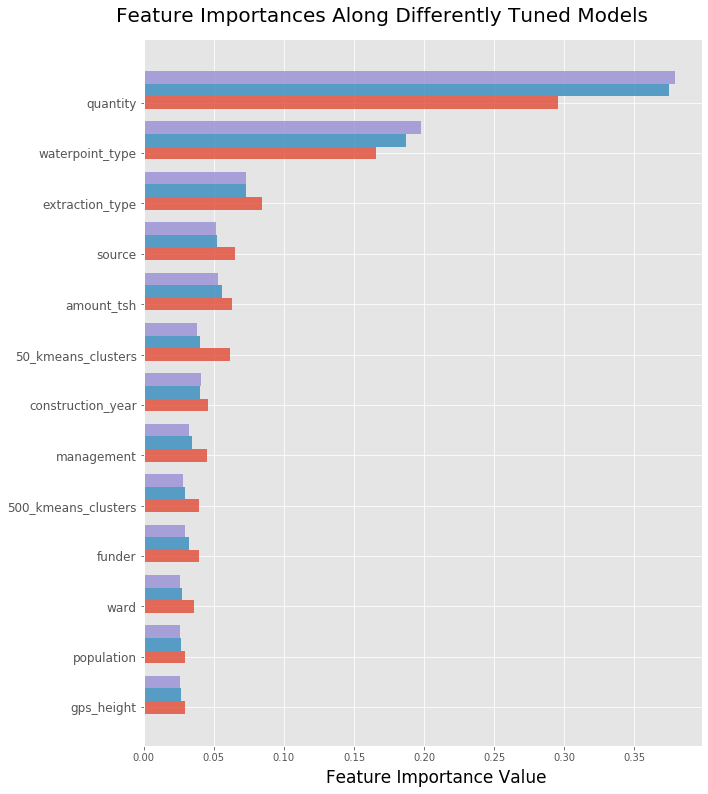

In [25]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10 , 13))

# Defining variables for plottling
n_groups = fidf['model_1'].nunique() 
index = np.arange(n_groups)
width = .25
opacity = .8
linewidth = 3

m_1 = plt.barh(index, fidf['model_1'], width, 
             alpha=opacity, linewidth = linewidth,
             label = 'Model 1')
m_2 = plt.barh(index + width, fidf['model_2'], width, 
             alpha=opacity,linewidth = linewidth,
             label = 'Model 2')
m_3 = plt.barh(index + 2*width, fidf['model_3'], width, 
             alpha=opacity, linewidth = linewidth,
             label = 'Model 3')

plt.yticks(ticks=np.arange(13), labels=fidf.index, fontsize=12)

plt.text(x = -0.02, y = 13.6, s = 'Feature Importances Along Differently Tuned Models',
        fontsize = 20, )
plt.text(x = 0.13, y = -1.5, s = 'Feature Importance Value',
        fontsize = 17, )

plt.show();

Something something model interpretability

Model performance could be related to the model prioritizing noisy data. 

### eli5/LIME

How do you determine whether or not a feature is noise? One approach is permuation importance. I'll be testing that using the eli5 library. eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.

I'll be using the GridSearchCV Model as it has the lowest standard deviation of the 3 models. 

In [36]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_2, 
                             scoring = 'accuracy',
                             n_iter = 10, 
                             random_state = 42)

perm.fit(X, y)

eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.1604 ± 0.0031,quantity
0.0754 ± 0.0017,extraction_type
0.0661 ± 0.0022,waterpoint_type
0.0637 ± 0.0016,construction_year
0.0612 ± 0.0017,gps_height
0.0564 ± 0.0014,population
0.0562 ± 0.0016,funder
0.0525 ± 0.0015,50_kmeans_clusters
0.0508 ± 0.0016,amount_tsh
0.0490 ± 0.0013,ward


### SHAP

SHAP is a library that utilizes Shapley values in order support model explainability. The technical definition of a Shapley value is the “average marginal contribution of a feature value over all possible coalitions.” In other words, Shapley values consider all possible predictions for an instance using all possible combinations of inputs. Because of this exhaustive approach, SHAP can guarantee properties like consistency and local accuracy.

In [33]:
import shap

I want to explain each step of this process as thoroughly as possible as it will be easy to brush over some of the finer details of the process for finding the shapley values and demonstrating them. To begin, I need to figure out the Shapley values of the model. Since this can be computationally expensive, I will be only running these tests on the model recommended by the BayesSearchCV. I'll be utilizing the [Tree Explainer](https://shap.readthedocs.io/en/latest/#shap.TreeExplainer) class and some of the default parameters. 

    shap.TreeExplainer(
            model,
            data=None,
            model_output='margin',
            feature_dependence='tree_path_dependent',
    )
    
Notice I will keep the default feature_dependence. If I wanted to change the model_output to `"probability"`, I would then change the feature_dependence to `"independent"`. In this case, I am looking for shapley values based on how the training data was distributed among the leaves. 

In [37]:
#Create a Tree explainer 
bm_exp = shap.TreeExplainer(model_2)
#calculate shapley values
y_pred=model_2.predict(X_val)
s_values = bm_exp.shap_values(X=X_val, y=y_pred)

This problem is a multi-class classification problem which makes it relatively difficult to interpret what features influence which potential prediction class. SHAP provides some degree of insight into what features played a role in a particular prediciton. For example. in the chart below `quantity` is a major factor in waterpumps that the not functioning or need repair. It is not as influential in determining pumps that are functioning whereas the extraction type plays an outsized role in that prediction. 

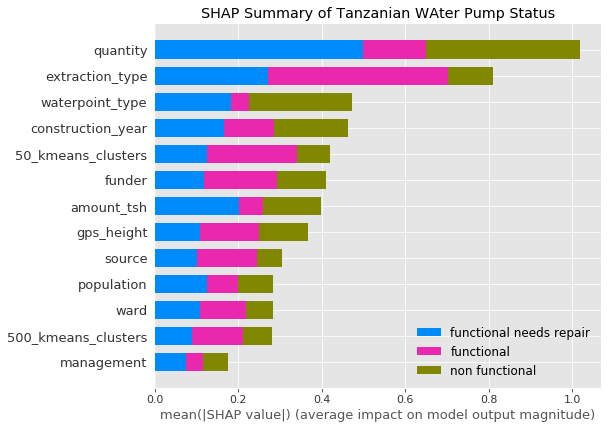

In [38]:
class_names=y_val.unique()
plt.style.use('ggplot')
plt.title('SHAP Summary of Tanzanian WAter Pump Status')

shap.summary_plot(s_values, X_val, plot_type="bar",
                  class_names=class_names,
                  title='SHAP Summary of Tanzanian Water Pump Status')

The next step with Shap is to look at individual prediction to root out the model's decision making process. This is extremely powerful when used in conjunction with a confusion matrix. 